In [1]:
# (Optional) Enable interactive plotting in Jupyter

# For Jupyter notebooks
%matplotlib notebook

# For Jupyter lab
# %matplotlib widget

In [2]:
%load_ext autoreload
%autoreload 2

In [4]:
import sys
import os
import numpy as np
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import shutil

cwd = os.getcwd()
pardir = os.path.abspath(os.path.join(cwd, ".."))
modeldir = os.path.abspath(os.path.join(pardir, "models"))

if pardir not in sys.path:
    sys.path.append(pardir)

from jDAS import JDAS

# Goal of this tutorial

The basic denoising tutorial (`basic_denoising_example.ipynb`) shows how to perform basic denoising with *jDAS*. The example data used in that tutorial are obtained during the same DAS experiment as the data that was used in the training of the model, and so no retraining is needed. In this tutorial, we are going to retrain the model to obtain better accuracy on "new" data. In practice, retraining the model is recommended in the following scenarios:

1. A new experiment was conducted (e.g. in a different location, or with different interrogator settings like the gauge length or maximum sensing distance).
2. The conditions during one experiment strongly vary. This can be the case when new noise sources are introduced (construction works on-land, microseismic noise, etc.), or when the signal-to-noise ratio significantly changes.
3. One particular event of interest, such as a major earthquake, occurs. In this case the model can be trained in "single-sample mode": instead of training on a large data set and optimising the model parameters for a (potentially) wide data range, the training is done on a very specific data range. Consequently, the _jDAS_ model will try to achieve the best denoising performance for this specific data set, at the cost of generalisation.

Note that multiple models can be trained for different conditions (e.g. nighttime/daytime, on-land and submarine segments of the cable, etc.).

# Step 1: Generate new data

As a simple example, we will generate some synthetic data. Standard Gaussian noise is low-pass filtered in space and time to artificially create spatio-temporal correlations. This will be the ground truth. We then generate spatially incoherent noise with the same frequency characteristics by randomly shuffling the rows of the original data. The model input data will be a superposition of the ground truth and noise. Since the noise has the same frequency characteristics as the ground truth, bandpass filtering will not be able to remove the noise.

The resulting (noisy) data will exhibit very different characteristics from the data on which the original model was trained. To see the importance of retraining the model, we will first denoise the new data with the default pretrained model. We will then retrain the model on the new data, and repeat the denoising operation.

In [5]:
# Visualisation parameters (will be reused)
imshow_kwargs = {
    "interpolation": "none",
    "aspect": "auto",
    "vmin": -2,
    "vmax": 2,
}

# Setting the random seed
rng = np.random.default_rng(42)

# Number of DAS channels, number of time samples
Nch, Nt = 500, 40 * 2048

# Generate the ground truth by low-pass filtering Gaussian random noise
data = rng.normal(size=(Nch, Nt))
data = gaussian_filter(data, sigma=(5, 50))

# Generate incoherent noise with the same frequency characteristics by
# shuffling the ground truth data along the channel axis
noise = data.copy()
rng.shuffle(noise, axis=0)

# Input data: ground truth + noise
noisy_data = data + noise

# Split the data 50-50 into a train and validation set.
# The train/validation data are normalised
Nsplit = int(0.5 * Nt)

train_data = np.expand_dims(noisy_data[:, :Nsplit], axis=0)
train_data = train_data / data.std()
val_data = np.expand_dims(noisy_data[:, Nsplit:], axis=0)
val_data = val_data / data.std()

To verify that everything is correct, we plot a subset of the data for visual inspection

<IPython.core.display.Javascript object>


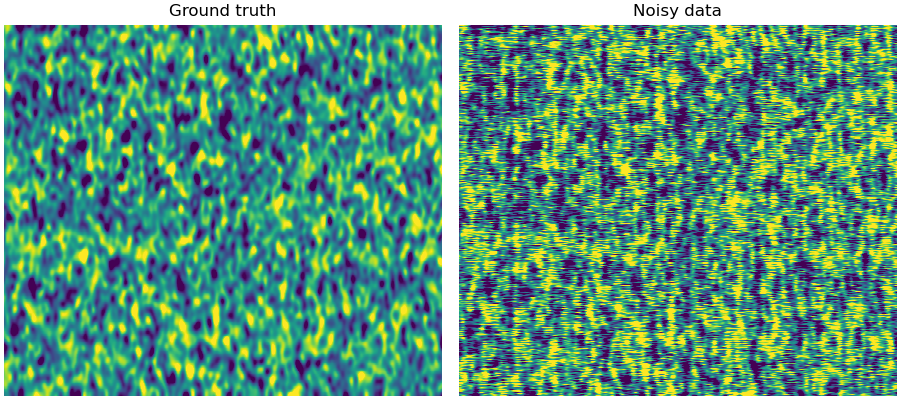

In [6]:
t_slice = slice(20_000, 30_000)

plt.close("all")
fig, axes = plt.subplots(ncols=2, figsize=(9, 4), constrained_layout=True, sharex="all", sharey="all")

axes[0].imshow(data[:, t_slice] / data.std(), **imshow_kwargs)
axes[0].set_title("Ground truth")

axes[1].imshow(noisy_data[:, t_slice] / data.std(), **imshow_kwargs)
axes[1].set_title("Noisy data")

for ax in axes:
    ax.axis("off")

plt.show()

# Performance without retraining

To check how well (or not) the standard pretrained model performs without additional retraining, we call the *jDAS* denoising routine without post-process filtering, and visualise the results. As expected, the model output bears hardly any resemblance to the input data and exhibits large boundary artifacts (recall that the data are split into 2048-sized chunks in time when passed to the model).

In [7]:
jdas = JDAS()
model = jdas.load_model()
pre_train = jdas.denoise(noisy_data)

print("Done")

2022-01-17 15:00:39.355304: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-17 15:00:39.814026: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7111 MB memory:  -> device: 0, name: Quadro P4000, pci bus id: 0000:65:00.0, compute capability: 6.1


Processing 1 / 40


2022-01-17 15:00:40.503783: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-01-17 15:00:40.957538: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201
2022-01-17 15:00:41.211136: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-01-17 15:00:41.211881: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-01-17 15:00:41.211894: W tensorflow/stream_executor/gpu/asm_compiler.cc:77] Couldn't get ptxas version string: Internal: Couldn't invoke ptxas --version
2022-01-17 15:00:41.212558: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-01-17 15:00:41.212595: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: Failed to launch ptxas
Relying on driver to perform ptx co

Processing 5 / 40
Processing 9 / 40
Processing 13 / 40
Processing 17 / 40
Processing 21 / 40
Processing 25 / 40
Processing 29 / 40
Processing 33 / 40
Processing 37 / 40
Done


<IPython.core.display.Javascript object>


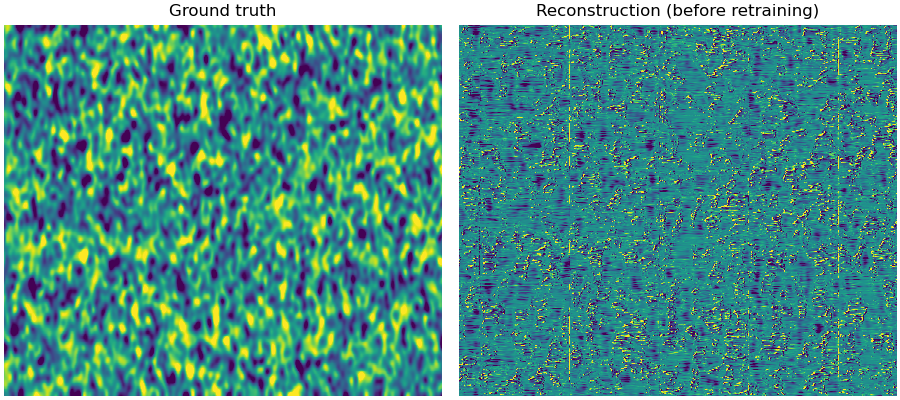

In [8]:
t_slice = slice(20_000, 30_000)

plt.close("all")
fig, axes = plt.subplots(ncols=2, figsize=(9, 4), constrained_layout=True, sharex="all", sharey="all")

axes[0].imshow(data[:, t_slice] / data.std(), **imshow_kwargs)
axes[0].set_title("Ground truth")
axes[1].imshow(pre_train[:, t_slice] / data.std(), **imshow_kwargs)
axes[1].set_title("Reconstruction (before retraining)")

for ax in axes:
    ax.axis("off")

plt.show()

# Data loader and callbacks

To prepare the retraining phase, we need to pass the training and validation data to a data loader. This data loader automatically creates mini-batches of randomly selected windows of data, with additional augmentations (polarity flip, time/space reversals). The `batch_size` is a user parameter that controls how many random samples are created per mini-batch. A smaller value will consume less memory, but will suffer from more stochastic noise during the gradient-descent optimisation. The `batch_multiplier` is a multiplicative factor that increases the number of mini-batches sampled per epoch, and so controls how often epoch statistics and log output are created.

In [11]:
batch_size = 32
batch_multiplier = 10

train_loader = jdas.init_dataloader(train_data, batch_size, batch_multiplier)
val_loader = jdas.init_dataloader(val_data, batch_size, batch_multiplier)

We can inspect a mini-batch sample by calling `__getitem__` (which fetches a mini-batch), and selecting one sample (`n`) from that batch. The output of the data loader will be

1. `sample`: the randomly selected and augmented sample, which is of size 11 channels x 2048 time samples.
2. `mask`: the mask that will be applied before the `sample` is passed to the model, which obscures one channel.
3. `masked_sample`: the sample with the complementary mask already applied. This is the target for the model output.

(32, 11, 2048, 1) (32, 11, 2048, 1) (32, 11, 2048, 1)


<IPython.core.display.Javascript object>


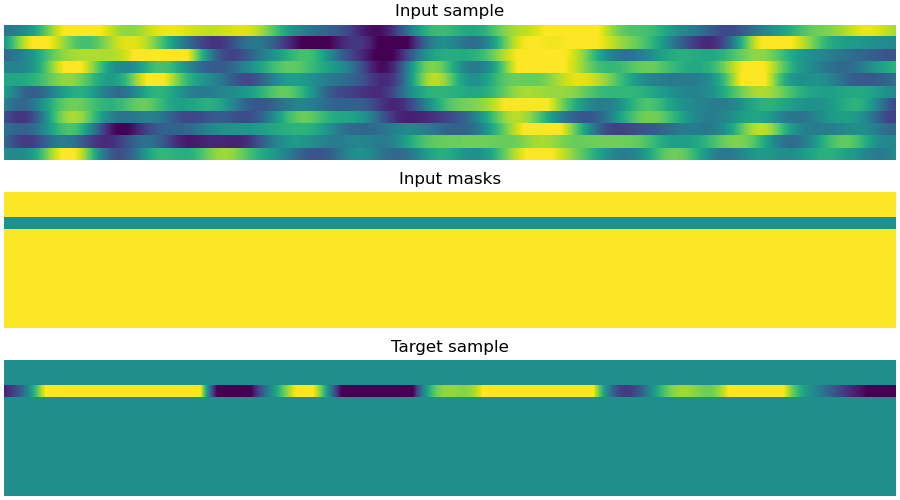

In [12]:
n = 0

(sample, mask), masked_sample = train_loader.__getitem__(0)

print(sample.shape, mask.shape, masked_sample.shape)

plt.close("all")
fig, axes = plt.subplots(nrows=3, figsize=(9, 5), constrained_layout=True, sharex="all", sharey="all")
axes[0].imshow(sample[n, :, :, 0] / sample[n].std(), **imshow_kwargs)
axes[0].set_title("Input sample")
axes[1].imshow(mask[n, :, :, 0] / mask[n].std(), **imshow_kwargs)
axes[1].set_title("Input masks")
axes[2].imshow(masked_sample[n, :, :, 0] / masked_sample[n].std(), **imshow_kwargs)
axes[2].set_title("Target sample")

for ax in axes:
    ax.axis("off")
    
plt.show()

For completeness, this tutorial also covers how to save the retrained model and log data. This is done through TensorFlow callbacks, which are loaded into the `JDAS` class. To record the training progress (aggregated statistics on the training and validation sets after each epoch), call the `callback_tensorboard` routine with the path at which to store the log files. To save the retrained model parameters, call `callback_checkpoint` with the path to the save file (it does not need to exist yet). Note that after each epoch the model performance is evaluated on the validation set, and only the best model state is kept.

Both these callbacks are entirely optional.

In [13]:
""" Callbacks """

model_name = "retrained_example"

logdir = os.path.join("logs", model_name)
if os.path.isdir(logdir):
    shutil.rmtree(logdir)
    
savefile = "saved-model.h5"
savedir = os.path.join("save", model_name)
if not os.path.isdir(savedir):
    os.makedirs(savedir)

tensorboard_callback = jdas.callback_tensorboard(logdir)
checkpoint_callback = jdas.callback_checkpoint(os.path.join(savedir, savefile))

# Retraining the model

We can now start retraining the model. Depending on how similar the new data are compared to the original data (on which the model was trained), this can take a few minutes. In this example, 10 epochs of retraining already produces acceptable results, but other data sets may require more epochs.

The previously defined callbacks are passed to the training routine. In case no progress monitoring of model state saving is needed, the relevant callbacks can be omitted from here.

In [14]:
model.fit(
    x=train_loader, validation_data=val_loader,
    callbacks=[tensorboard_callback, checkpoint_callback],
    epochs=10, verbose=1, batch_size=batch_size
)

print("Done")

Epoch 1/10
14/14 [==============================] - 3s 112ms/step - loss: 0.1548 - val_loss: 0.1570
Epoch 2/10
14/14 [==============================] - 1s 98ms/step - loss: 0.1299 - val_loss: 0.1229
Epoch 3/10
14/14 [==============================] - 1s 98ms/step - loss: 0.1176 - val_loss: 0.1269
Epoch 4/10
14/14 [==============================] - 1s 99ms/step - loss: 0.1141 - val_loss: 0.1063
Epoch 5/10
14/14 [==============================] - 1s 98ms/step - loss: 0.1137 - val_loss: 0.1071
Epoch 6/10
14/14 [==============================] - 1s 98ms/step - loss: 0.1171 - val_loss: 0.1121
Epoch 7/10
14/14 [==============================] - 1s 99ms/step - loss: 0.1128 - val_loss: 0.1083
Epoch 8/10
14/14 [==============================] - 1s 97ms/step - loss: 0.1075 - val_loss: 0.1040
Epoch 9/10
14/14 [==============================] - 1s 97ms/step - loss: 0.1106 - val_loss: 0.1221
Epoch 10/10
14/14 [==============================] - 1s 98ms/step - loss: 0.1112 - val_loss: 0.1060
Done


# Retrained model performance

Lastly, we evaluate the denoising performance of the newly trained model. While we already have the retrained model in memory, we first reload best the model that was saved to disk, and then make another call to `denoise` with the new model in memory.

In [16]:
# model = jdas.load_model(os.path.join(savedir, savefile))
post_train = jdas.denoise(noisy_data)

print("Done")

Processing 1 / 40
Processing 5 / 40
Processing 9 / 40
Processing 13 / 40
Processing 17 / 40
Processing 21 / 40
Processing 25 / 40
Processing 29 / 40
Processing 33 / 40
Processing 37 / 40
Done


As expected the new model performs much better in recovering the original ground truth data.

<IPython.core.display.Javascript object>


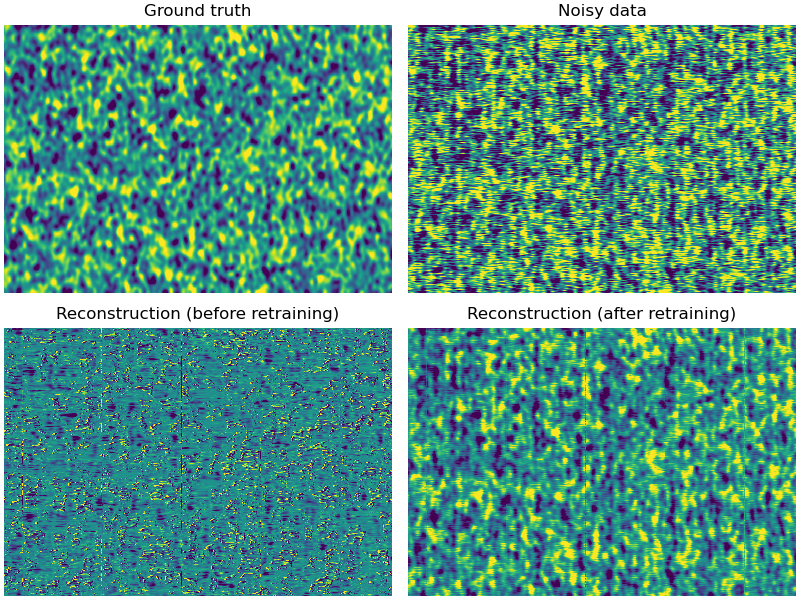

In [17]:
t_slice = slice(20_000, 30_000)

plt.close("all")
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 6), constrained_layout=True, sharex="all", sharey="all")

axes = axes.ravel()

axes[0].imshow(data[:, t_slice] / data.std(), **imshow_kwargs)
axes[0].set_title("Ground truth")

axes[1].imshow(noisy_data[:, t_slice] / data.std(), **imshow_kwargs)
axes[1].set_title("Noisy data")

axes[2].imshow(pre_train[:, t_slice] / data.std(), **imshow_kwargs)
axes[2].set_title("Reconstruction (before retraining)")

axes[3].imshow(post_train[:, t_slice] / data.std(), **imshow_kwargs)
axes[3].set_title("Reconstruction (after retraining)")

for ax in axes:
    ax.axis("off")

plt.show()

<IPython.core.display.Javascript object>


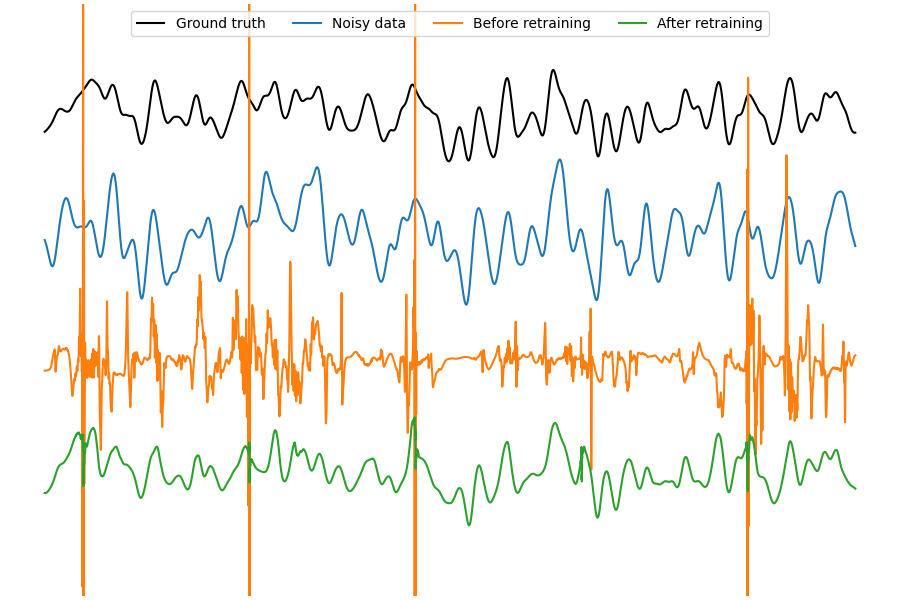

In [18]:
n = 300

plt.close("all")
plt.figure(figsize=(9, 6), constrained_layout=True)

plt.plot(data[n, t_slice], "k", label="Ground truth")
plt.plot(noisy_data[n, t_slice] - 0.1, "C0", label="Noisy data")
plt.plot(pre_train[n, t_slice] - 0.2, "C1", label="Before retraining")
plt.plot(post_train[n, t_slice] - 0.3, "C2", label="After retraining")

plt.legend(loc="upper center", ncol=4)

plt.ylim((-0.4, 0.1))
plt.axis("off")
plt.show()

# Clean-up

In [19]:
if os.path.isdir("logs"):
    shutil.rmtree("logs")
    
if os.path.isdir("save"):
    shutil.rmtree("save")